In [1]:
%pip install geopandas

     |████████████████████████████████| 1.1 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.5 MB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 5.3 MB/s eta 0:00:011
     |████████████████████████████████| 341 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 502 kB 13.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import wkt
from geopandas import GeoSeries

In [4]:
def readPolygonFromFile(filename):
  with open(filename) as f:
      str = [word for line in f for word in line.split(", ")]
  
  geom = []
  for i in range(len(str)):
      lon, lat = str[i].split(" ")
      geom.append((float(lon), float(lat)))
  p1 = Polygon(geom)
  poly_gdf = gpd.GeoDataFrame(geometry = [p1], crs = "EPSG:3346")
  return poly_gdf

In [10]:
exteriorLine = readPolygonFromFile("kaunas.txt")
exteriorLineScaled = exteriorLine.to_crs(epsg=4326)

In [8]:
# importing economiic data file
geo_data = gpd.read_file('100eco/grid100.shp')
geo_data = geo_data.to_crs(epsg=4326)

geo_data_eco = geo_data[geo_data.metai == 2021]

In [9]:
# importing population data file
geo_data = gpd.read_file('100pop/grid100.shp')
geo_data_pop = geo_data.to_crs(epsg=4326)

In [11]:
# merging datasets
geo_data_pop = geo_data_pop.rename(columns={'GRID_ID': 'grid_id', 'POP': 'pop'})
geo_data_merged = geo_data_eco.merge(geo_data_pop, on='grid_id', how='outer')
geo_data_merged['a'] = geo_data_merged['a'].fillna(0)
geo_data_merged['b_c_d_e'] = geo_data_merged['b_c_d_e'].fillna(0)
geo_data_merged['f'] = geo_data_merged['f'].fillna(0)
geo_data_merged['g_h_i'] = geo_data_merged['g_h_i'].fillna(0)
geo_data_merged['pop'] = geo_data_merged['pop'].fillna(0)

In [12]:
# Z-Score Normalization
def linearNormalize(dataset):
    print(dataset.head())
    print("min", dataset.min())
    print("max", dataset.max())
    return (dataset-dataset.min())/ (dataset.max() - dataset.min())

def zNormalize(dataset):
    return (((dataset - dataset.mean()) / dataset.std()) + 1) / 2

def meanNormalize(dataset1, dataset2):
    return (dataset1 + dataset2) / 2

In [13]:
def getColor(val):
    red = int(255*(1 - max(min(val, 1),0)))
    green = int(255*max(min(val, 1),0))
    #print("c", val, red, green)
    color = '#%02x%02x%02x' % (red, green, 0)
    #print(color)
    return color

def drawRectangle(x, y, val):
    return matplotlib.patches.Rectangle((x, y), 0.00159, 0.00004, color=getColor(val)+'33')

   fid    a  g_h_i    f    j   pajamos   metai    k    l dsk_  ...  \
0  1.0  0.0    0.0  2.0  0.0    111968  2021.0  0.0  0.0    2  ...   
1  2.0  0.0    3.0  1.0  0.0  18370645  2021.0  0.0  0.0  672  ...   
2  3.0  0.0    0.0  0.0  0.0        -1  2021.0  0.0  2.0   -1  ...   
3  4.0  0.0    3.0  0.0  0.0   2472752  2021.0  0.0  0.0   30  ...   
4  5.0  0.0    0.0  0.0  0.0   1320560  2021.0  0.0  0.0   28  ...   

   OCP_employ  OCP_other  OCP_empl_1 Shape__Are  Shape__Len  \
0         9.0        NaN        38.0    10000.0       400.0   
1         NaN        NaN        81.0    10000.0       400.0   
2         NaN        NaN         NaN        NaN         NaN   
3         NaN        NaN         NaN        NaN         NaN   
4         NaN        NaN         NaN        NaN         NaN   

                                          geometry_y  eco_normalised  \
0  POLYGON ((21.12821 55.72181, 21.12815 55.72271...        0.784163   
1  POLYGON ((21.13483 55.71837, 21.13477 55.71927...    

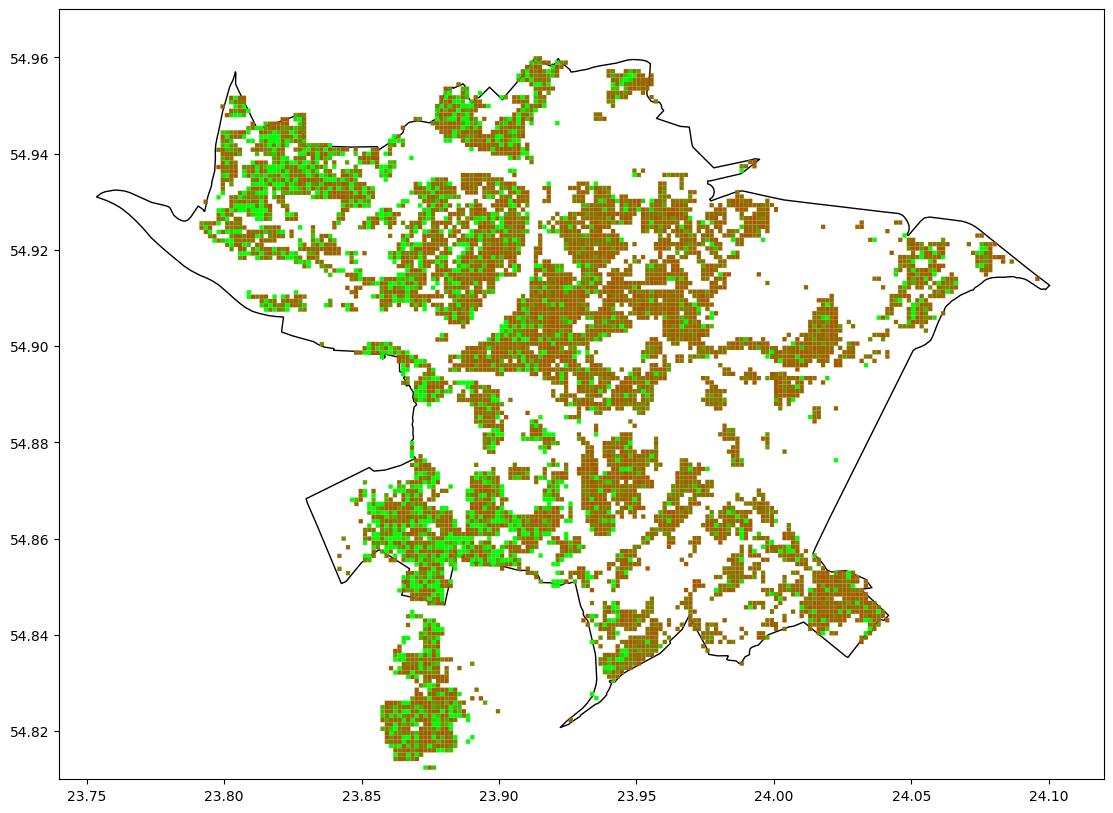

Text(0.5, 0.98, 'Relevant economic sectors')

In [14]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(1,1)

# initialise a dataframe with the right amount of rows
geo_data_merged['eco_normalised'] = geo_data_merged['a']
geo_data_merged['pop_normalised'] = geo_data_merged['a']

plt.ylim((54.81, 54.97))
plt.xlim((23.74, 24.12))

exteriorLineScaled.plot(ax = ax, facecolor="none", edgecolor="black")

for index, row in geo_data_merged.iterrows():
    geo_data_merged.at[index,'eco_normalised'] = int(row['a']) + int(row['b_c_d_e']) + int(row['f']) + int(row['g_h_i'])

geo_data_merged['eco_normalised'] = zNormalize(geo_data_merged['eco_normalised'])
geo_data_merged['pop_normalised'] = zNormalize(geo_data_merged['pop'])
geo_data_merged['normalised'] = meanNormalize(geo_data_merged['eco_normalised'], geo_data_merged['pop_normalised'])

geo_data_merged['color'] = geo_data_merged['normalised'].apply(getColor)

print(geo_data_merged.head())
geo_data_merged_gdf = gpd.GeoDataFrame(geo_data_merged, geometry='geometry_y')

geo_data_merged_gdf.plot(facecolor=geo_data_merged_gdf.color, ax=ax)
plt.show()

fig.suptitle('Relevant economic sectors')

In [15]:
import time

In [16]:
def get_normalized_value_at_coordinates(dataframe, x, y):
    point = Point(x, y)

    for index, row in dataframe.iterrows():
        polygon = row['geometry_y']

        if polygon is not None and polygon.contains(point):
            return row['normalised']

    # If no polygon contains the point at the coordinates, return 0
    return 0

start = time.time()
print("Almost best case:", get_normalized_value_at_coordinates(geo_data_merged, 21.13, 55.72), "(",(time.time() - start), "s)")
start = time.time()
print("Classic case:", get_normalized_value_at_coordinates(geo_data_merged, 23.90, 54.895), "(",(time.time() - start), "s)")
start = time.time()
print("Worst case:", get_normalized_value_at_coordinates(geo_data_merged, 23.90, 54.82), "(",(time.time() - start), "s)")

Almost best case: 0.9027156635406128 ( 0.4926576614379883 s)
Classic case: 1.1749985238885419 ( 1.918731927871704 s)
Worst case: 0 ( 7.124932527542114 s)


In [ ]:
# SOME OLD CODE AND TESTS (DON'T LOOK AT IT)
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(1,1)

# initialise a dataframe with the right amount of rows
geo_data_merged['eco_normalised'] = geo_data_merged['a']

plt.ylim((54.81, 54.97))
plt.xlim((23.74, 24.12))

exteriorLineScaled.plot(ax = ax, facecolor="none", edgecolor="black")

for index, row in geo_data_merged.iterrows():
    geo_data_merged.at[index,'eco_normalised'] = int(row['a']) + int(row['b_c_d_e']) + int(row['f']) + int(row['g_h_i'])

geo_data_merged['eco_normalised'] = zNormalize(geo_data_merged['eco_normalised'])

i=0
for index, row in geo_data_merged.iterrows():
    i+=1
    #row['eco_normalised']
    #geometry = wkt.loads(row['geometry_y'])
    #---if i < 10:
        #---geometry = row['geometry_y']
        #---gdf = gpd.GeoDataFrame({'geometry': [geometry]})
    
        # Plot the polygon with the specified color
        #---gdf.plot(color=getColor(row['eco_normalised'])+'33', ax = ax)
    #if i < 10:
        #print(row)
        #print("coos: ", , row['eco_normalised'])
#for index, row in geo_data_merged.iterrows():
    #geo_data_merged.at[index,'normalised'] = str(row['normalised'])

#print(geo_data_merged.head())
#print(geo_data_merged[['grid_id','metai','a','b_c_d_e','f','g_h_i','a_b_c_d_e_f_g_h_i']].head())
print(geo_data_merged[['grid_id','eco_normalised']].head())


#geo_data_merged.plot(column = geo_data_merged.eco_normalised, ax = ax)

i=0
for index, row in geo_data_merged.iterrows():
    i+=1
    if i < 10:
        geometry = row['geometry_y']
        gdf = gpd.GeoDataFrame({'geometry': [geometry]})
    
        gdf.plot(color=getColor(row['eco_normalised']), ax=ax)

#for i in range(35):
    #print("range :",i)
    #rect = drawRectangle()
    #ax.add_patch(rect)
#plt.show()


fig.suptitle('Relevant economic sectors')